In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from salishsea_tools.nc_tools import scDataset

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

%matplotlib inline

In [2]:
def get_files(dirname, fname, grid):
    files = []    
    for item in os.listdir(dirname):
        if fnmatch.fnmatchcase(item, fname + grid + "*.nc"):
            files += [os.path.join(dirname, item)]
    files.sort(key=os.path.basename)
    return files

In [36]:
def vel_timeseries(dirname, fname, dep_ind):
    
    filesU = get_files(dirname, fname, 'grid_U') 
    print('files')
    
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(filesU) as dsU:
        vozocrtx0 = dsU.variables['vozocrtx'][:,dep_ind,y,x]
        print('U')
        sozotaux = dsU.variables['sozotaux'][:,0,0]
        depthu = dsU.variables['depthu'][:]
        nav_lat = dsU.variables['nav_lat'][y,x]
        nav_lon = dsU.variables['nav_lon'][y,x]

    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,dep_ind,y,x]

    umask = np.tile(umask0, (len(sozotaux), 1, 1))

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    
    return vozocrtx, umask, depthu, sozotaux, nav_lat, nav_lon

In [38]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'
fname = "1_MCKNZ_1h_20170101_20170120_*"

In [39]:
dep_ind = 9
vozocrtxC, umaskC, depthuC, sozotauxC, nav_latC, nav_lonC = vel_timeseries(dirname, fname, dep_ind)

files
U


In [32]:
xsC = np.arange(vozocrtxC.shape[-1])
ysC = np.arange(vozocrtxC.shape[-2])

In [45]:
def vel_timeseriesP(dirname, fname, dep_ind):
    
    filesU = get_files(dirname, fname, 'grid_U') 
    print('files')
    
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(filesU) as dsU:
        vozocrtx = dsU.variables['vozocrtx'][:,dep_ind,y,x]
        print('U')
        sozotaux = dsU.variables['sozotaux'][:,0,0]
        depthu = dsU.variables['depthu'][:]
        nav_lat = dsU.variables['nav_lat'][y,x]
        nav_lon = dsU.variables['nav_lon'][y,x]
    
    return vozocrtx, depthu, sozotaux, nav_lat, nav_lon

In [46]:
fname = "MCKNZ_1h_20170101_20170120_*"
dep_ind = 9
vozocrtxP, depthuP, sozotauxP, nav_latP, nav_lonP = vel_timeseriesP(dirname, fname, dep_ind)

files
U


In [33]:
xsP = np.arange(vozocrtxP.shape[-1])
ysP = np.arange(vozocrtxP.shape[-2])

In [21]:
def get_1day_avg(vel, day_start, day_end):
    day = slice(day_start*24, day_end*24, None)
    vel_day = np.mean(vel[day, ...], axis=0)
    return vel_day

In [42]:
def plot_vel_snapshots(vel_all, xs, ys, vm, ttl):
    cmap = plt.get_cmap(cmo.cm.balance)
    cmap.set_bad('wheat')
    fig, axes = plt.subplots(3, 4, figsize=(20,20), sharey=True)
    for ax, n in zip(axes.flatten(), np.arange(12)):
        vel_dayn = get_1day_avg(vel_all, n, n+1)
        p = ax.pcolormesh(xs, ys, vel_dayn, vmin=-1*vm, vmax=vm, cmap=cmap)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        #ax.set_xlim([0, xs[-1]])
        #ax.set_ylim([0, ys[-1]])
        ax.set_title('Day '+str(n+1), fontsize=16)
        if n==0:
            fig.colorbar(p, ax=ax)
    fig.tight_layout(w_pad=0.1, h_pad=0.25)
    fig.suptitle(ttl+' Profile at Depth '+str(np.round(depthuC[dep_ind],1))+' m', fontsize=20)
    plt.subplots_adjust(top=0.92)
    return fig

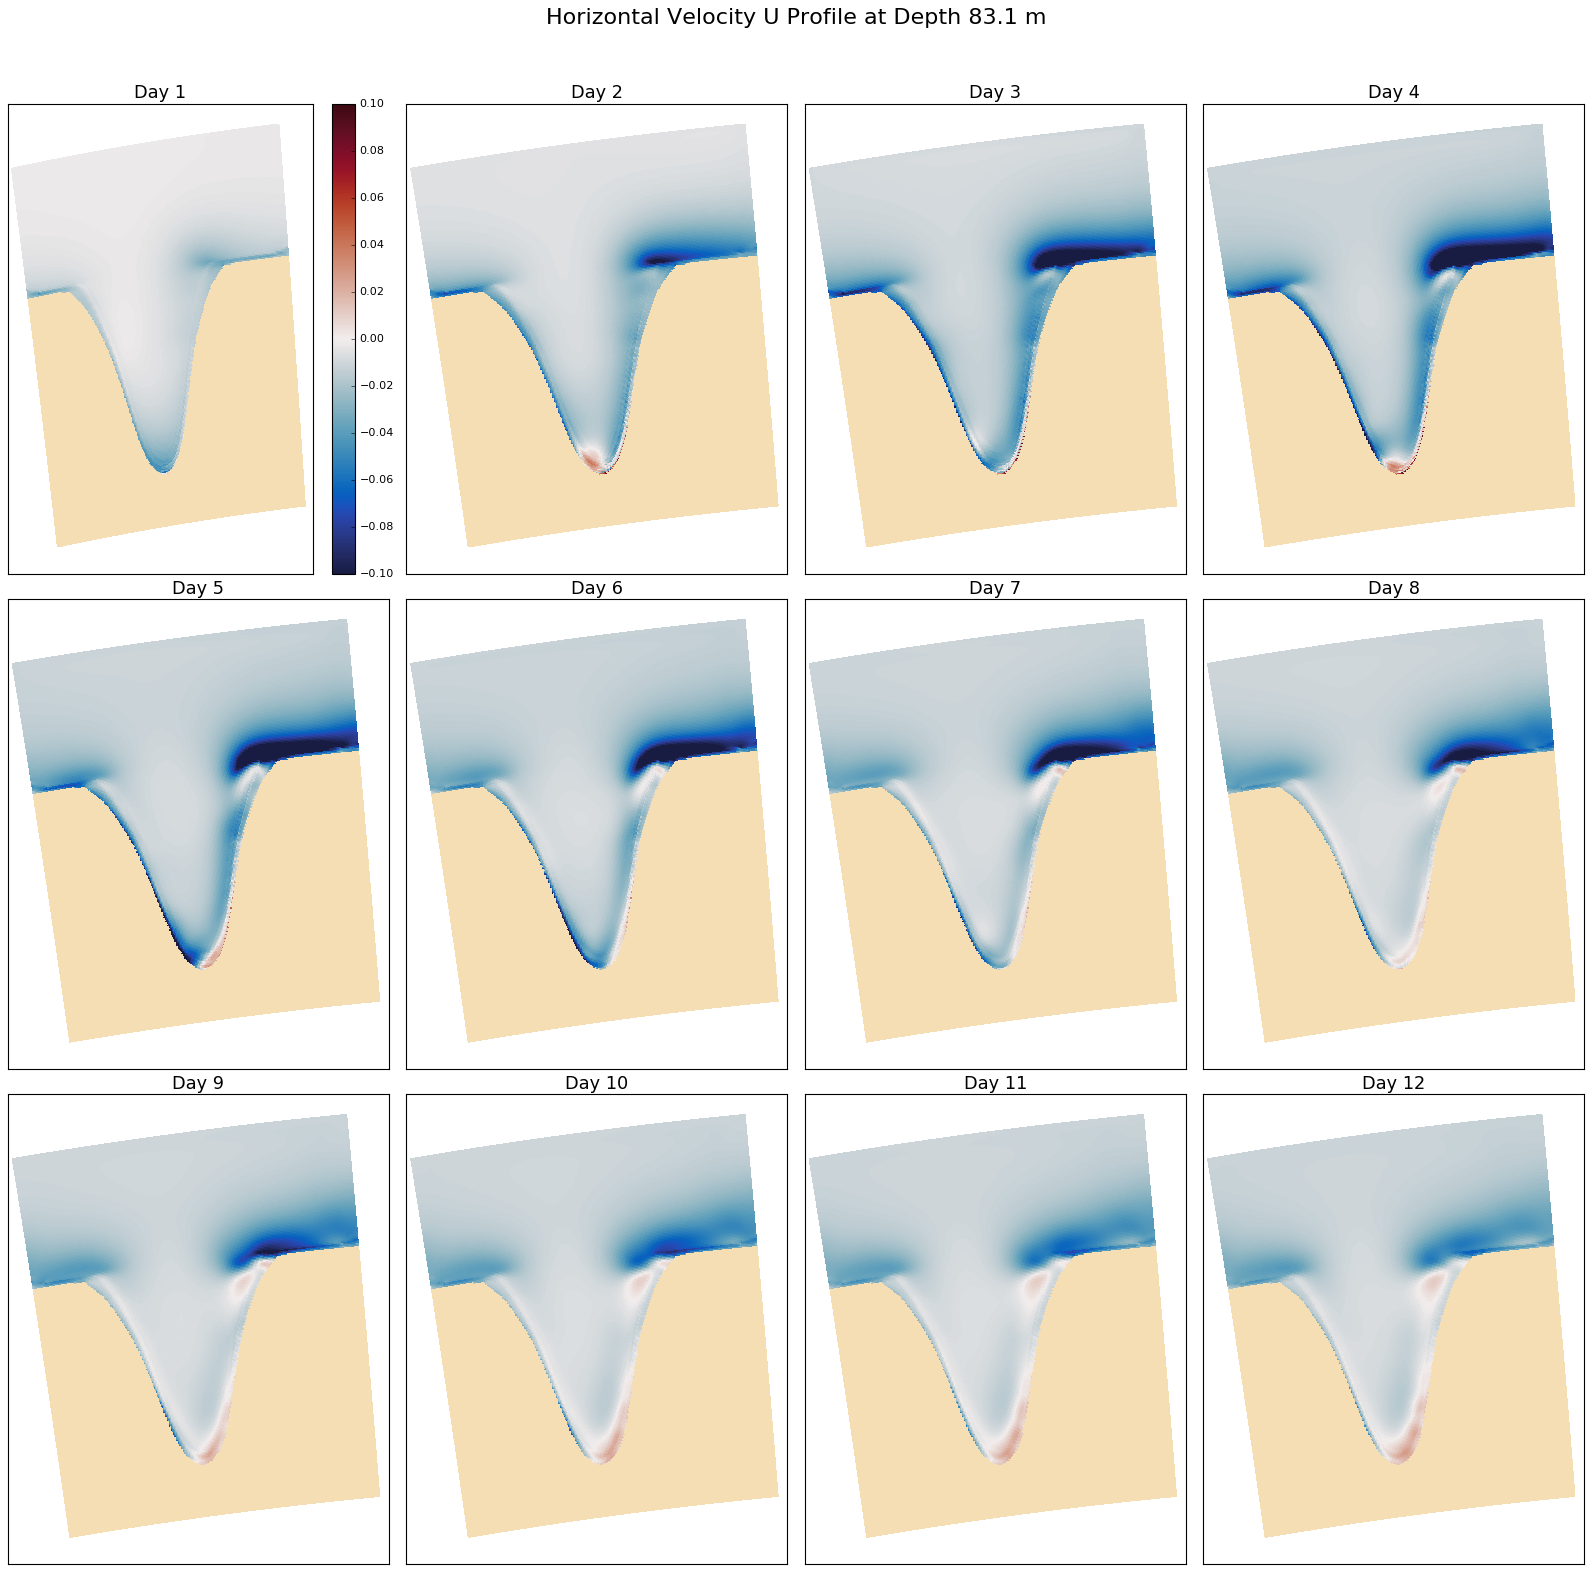

In [43]:
fig = plot_vel_snapshots(vozocrtxC, nav_lonC, nav_latC, 0.1, 'Horizontal Velocity U')

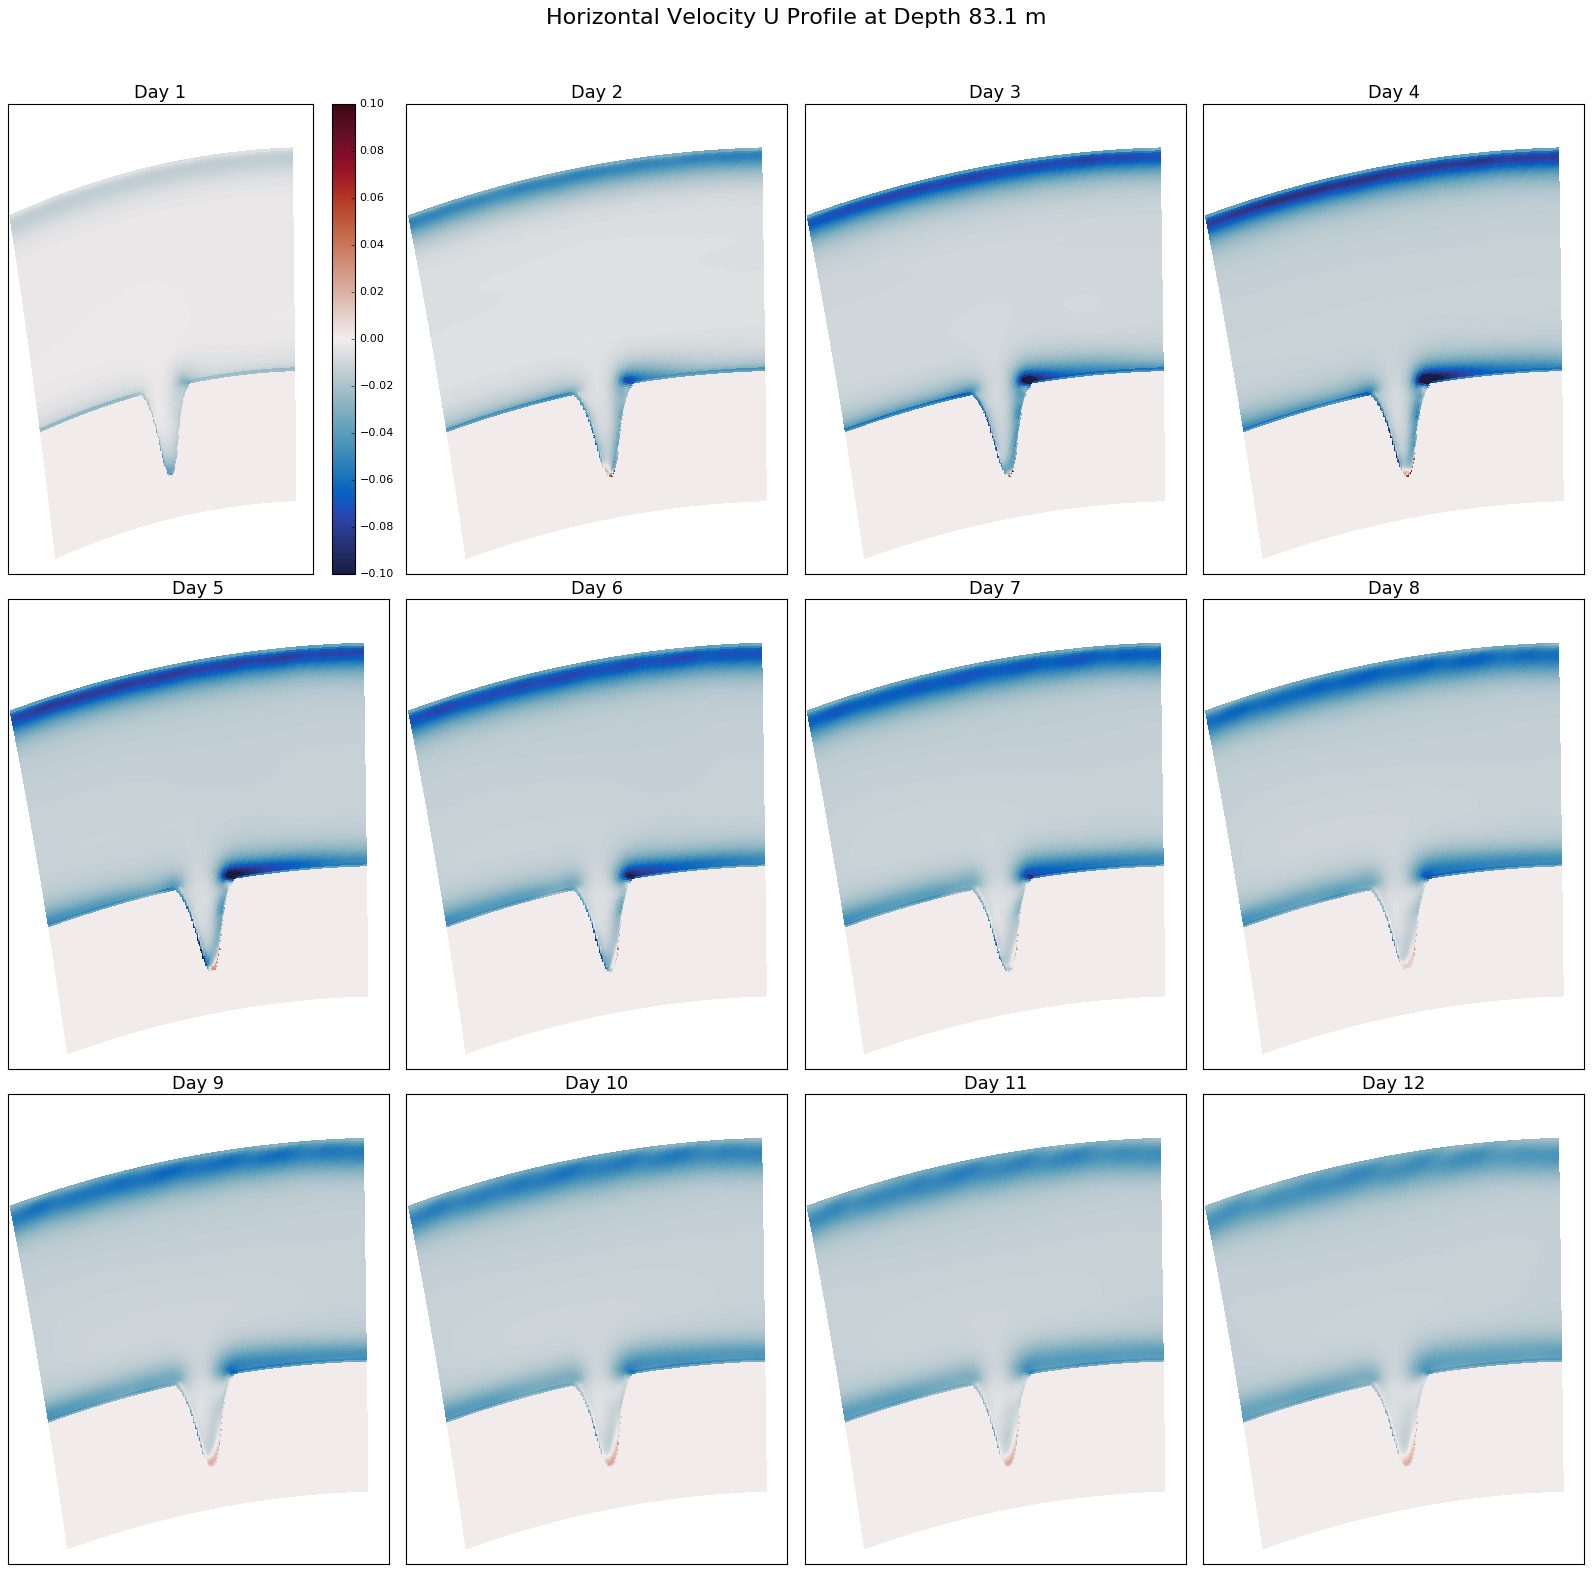

In [47]:
fig = plot_vel_snapshots(vozocrtxP, nav_lonP, nav_latP, 0.1, 'Horizontal Velocity U')

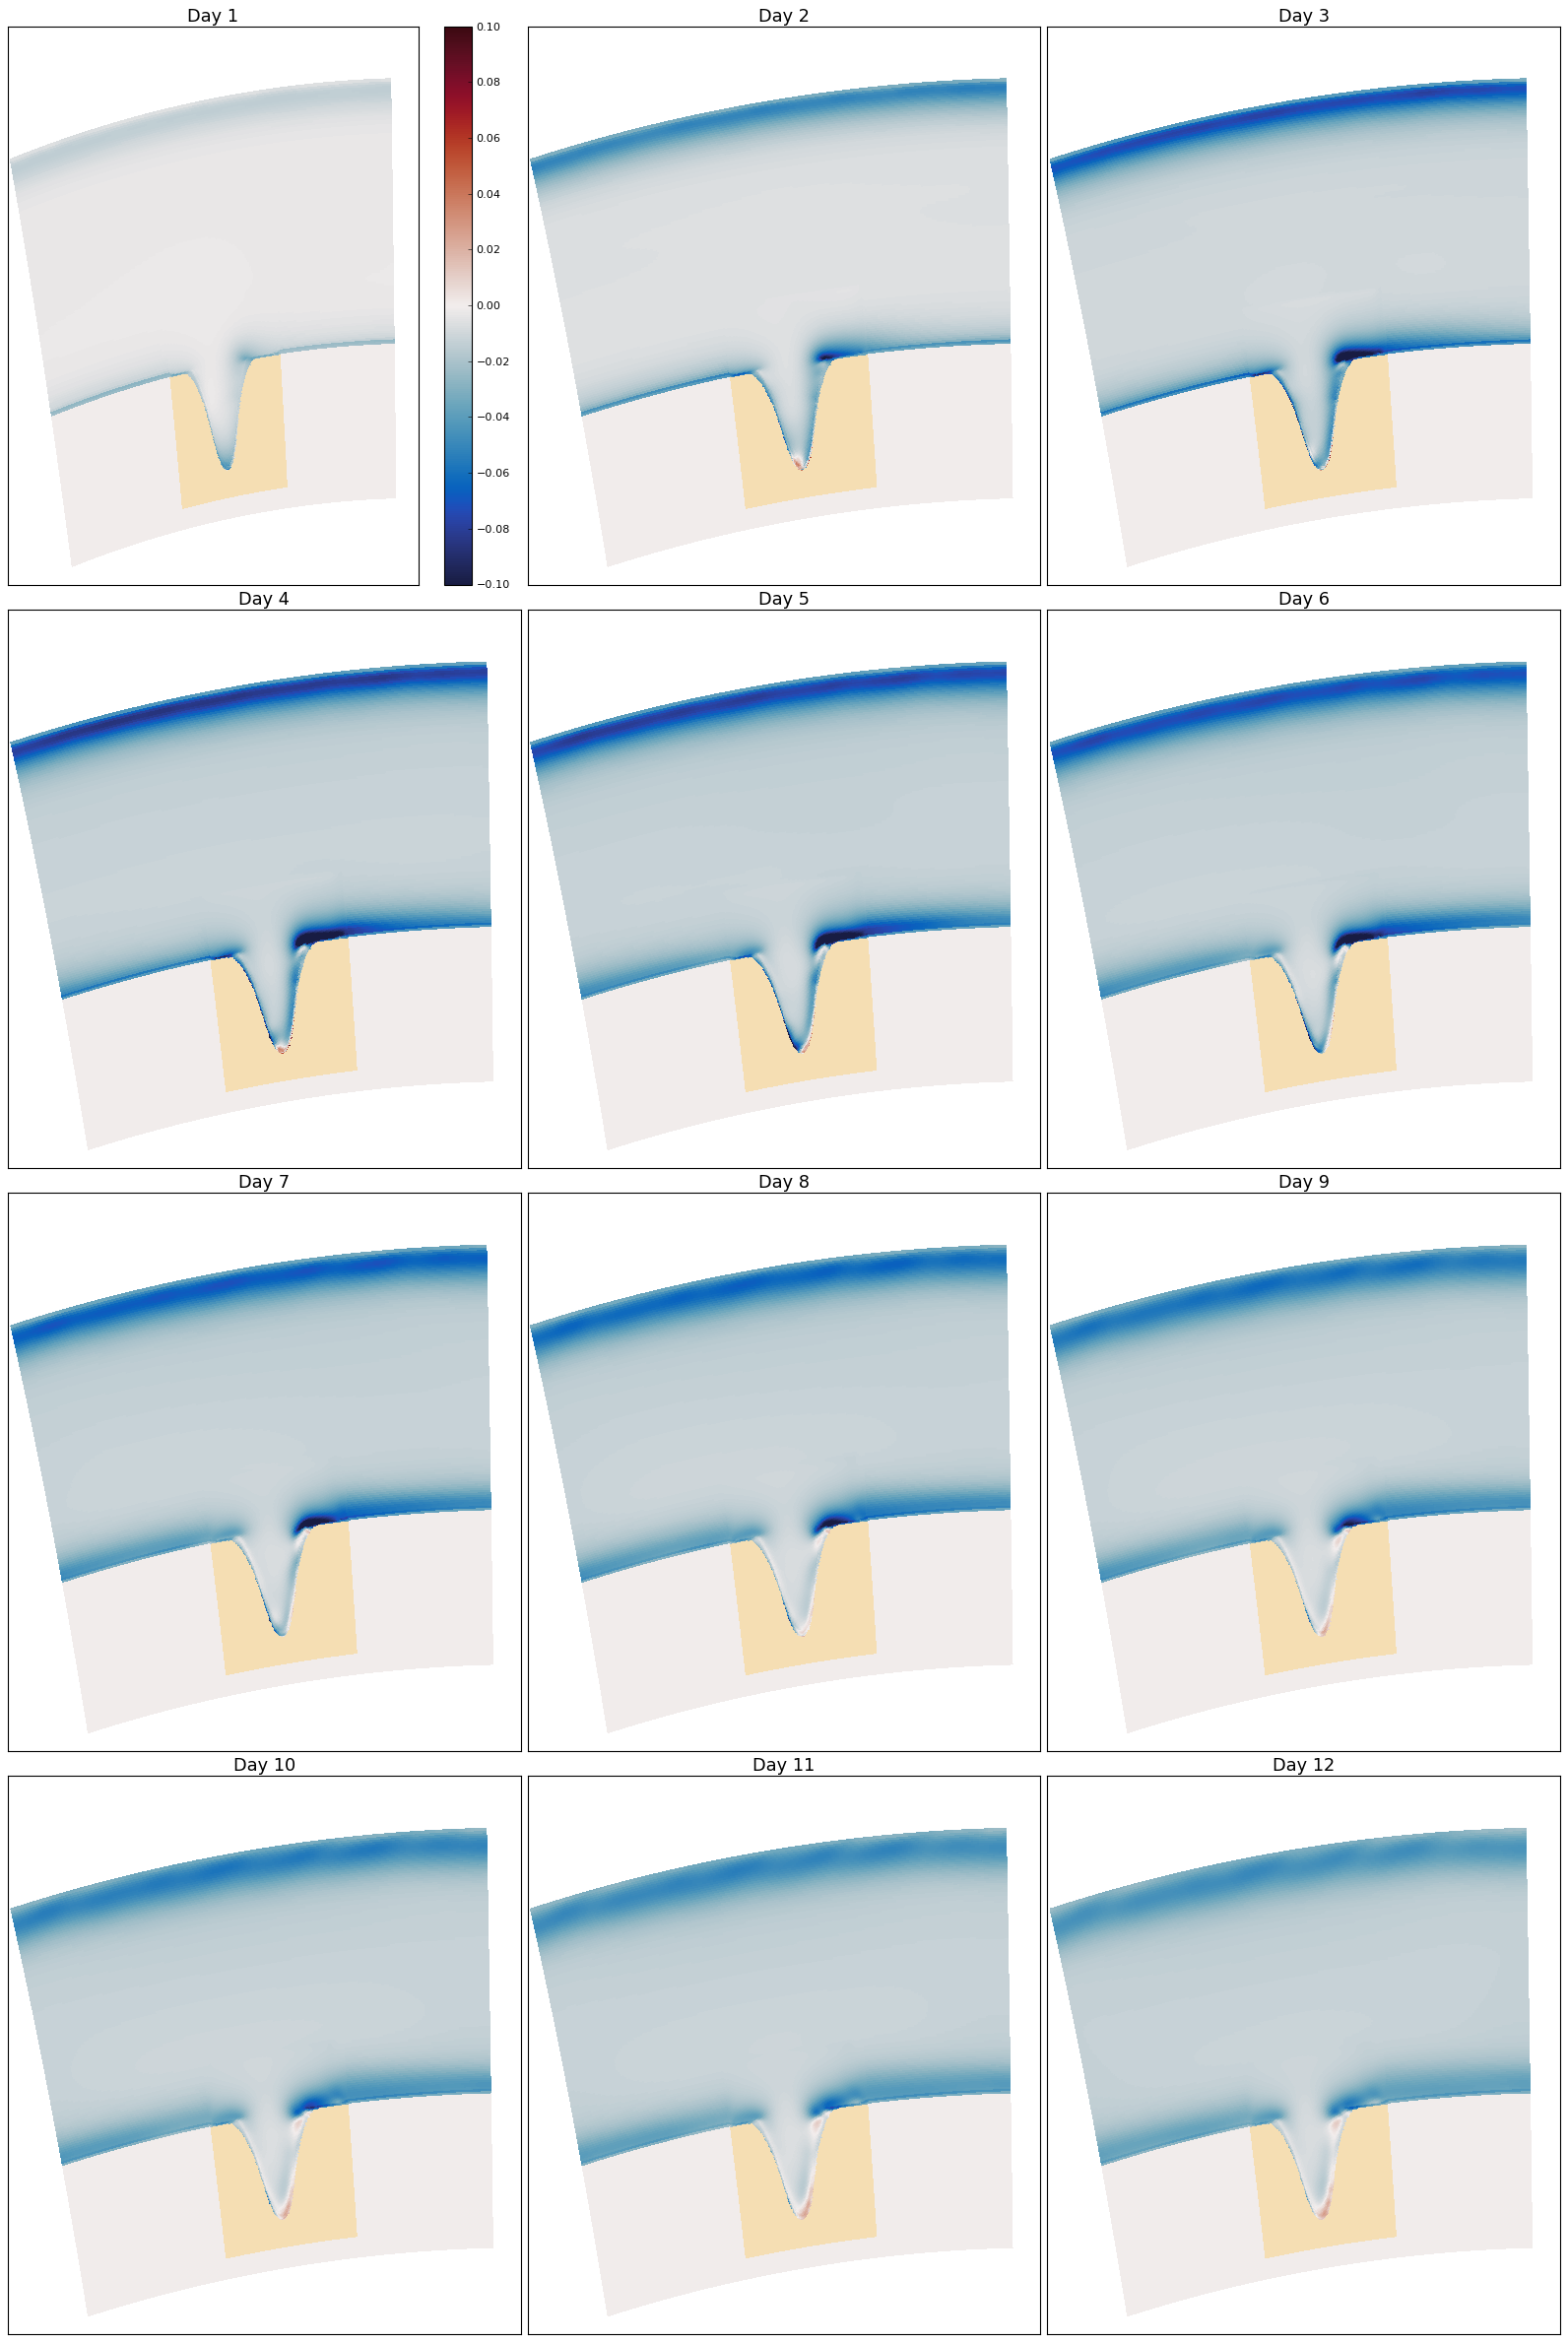

In [54]:
vm=0.1
cmap = plt.get_cmap(cmo.cm.balance)
cmap.set_bad('wheat')
fig, axes = plt.subplots(4, 3, figsize=(20,32), sharey=True)
for ax, n in zip(axes.flatten(), np.arange(12)):
    ax.pcolormesh(nav_lonP, nav_latP, get_1day_avg(vozocrtxP, n, n+1), vmin=-1*vm, vmax=vm, cmap=cmap)
    p = ax.pcolormesh(nav_lonC, nav_latC, get_1day_avg(vozocrtxC, n, n+1), vmin=-1*vm, vmax=vm, cmap=cmap)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_title('Day '+str(n+1), fontsize=16)
    if n==0:
        fig.colorbar(p, ax=ax)
fig.tight_layout(w_pad=0.1, h_pad=0.25)
#fig.suptitle(ttl+' Profile at Depth '+str(np.round(depthuC[dep_ind],1))+' m', fontsize=20)
plt.subplots_adjust(top=0.92)
